* [Organising Data](#first-bullet)
* [Formatting the Data](#second-bullet)
* [Class Imbalance](#third-bullet)

# Preparing the Data
This notebook will allow the user to read in the data from Kaggle and prepare it for training and testing. With a few minor changes to code, the user can change: the train/test/validation split sizes, the classes to be predicted (e.g. bacterial/viral/healthy or pneumonia/healthy), the shape of the images for analysis and more.
I have explicitly written the code out for the reading the image data and augmentations so the reader can try to understand what is going on.

## [Organising the Data](#first-bullet)

### Creating Three Classes from Two
This dataset is from kaggle and can be found here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
<br> The original dataset has already split the data into train, test and validation sets before splitting them into cases of Pneumonia and Normal (healthy) lungs. In reality Pneumonia can be caused by a bacterial infection or a viral one.
<br> For this project, I wish to see if the model can solve a multi-class problem as well as a binary one. Using Convolutional Neural Networks to classify either cases of Pneumonia vs. healthy lungs, before further breaking the pneumonia class down into viral and bacterial. To do so we must create our own classes which requires splitting the images up differently to how this dataset is provided - such that there are 3 different classes: Normal (healthy), Bacterial and Viral.

###  Train, Test and Validation Split and Class Imbalance
I will further create a train, test and validation split based around these classes. The test set will remained untouched and unseen until the final model is tested  in the third notebook. Validation is used during training to aid the user in avoiding overfitting of the training data.
<br> We will also see there is a class imbalance in the dataset which will bias our algorithm in its classifcation. This also makes the accuracy metric (used to evaluate how "good" the model is at classifying images) misleading and not a valid representation of the true model performance.
<br>
## [Formatting the Data](#second-bullet)

### Resizing Images
As the dataset is a few thousand images all with large resolution we will have to resize these such that the training of our model doesnt take too long. This will be something to consider in optimization of the model too - if transfer . learning is used (such as from VGG16) then the image will have to be of a certain shape and color scheme (grayscale or RGB).

### Rescaling
This is also known as normalization. Each pixel in an image has a value of 0-255 depending on its contrast. Each image will contain a varying number of each value, meaning a different range of values -  a larger range will contribute more to the loss whereas a smaller range has a smaller contribution. When this is put into our model the network the weights update accordingly. We want each image treated equally so by scaling, we put all the values in the same range 0-1.

## [Class Imbalance](#third-bullet)
### Image Generation
To account for the inital class imbalance we can create new images using the data in our posession. We can do this by flipping, stretching and rotating the images - as long as the augmentation matches what could happen with an actual x-ray image.
<br> It is important to note that in this step we will NOT be generating new data IN ADDITION to our training data, but rather we REPLACE the training data in each batch with the augmented images. This is known as "on-the-fly" image generation and is the most commonplace method.

### Class Weighting
An alternative method to data generation is weighting the classes. This will bias the learning so that the undersampled classes are more heavily weighted and therefore all classes are treated equally. This restores the validity of the accuracy metric for model evaluation.
<br> While this method has the advantages of being quicker to execute and simpler so less can go wrong, we lose out on training the model on a larger dataset so are more prone to overfitting or worse model performance (on the validation/test sets).




<br>

## Organising Data <a class="anchor" id="first-bullet"></a>


### Import Libraries and Set Seed for Reproducibilty

In [1]:
%load_ext autoreload
%autoreload 2
import os
import data_prep as dp
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Set the environment seed for Python
os.environ['PYTHONHASHSEED'] = '0'

seed=101

# Set seed for Numpy, TensorFlow and for image augmentation sequence
np.random.seed(seed)
# aug.seed(seed)

### Storing the Data Properly
We will create a new directory for all images and store them within train, test and validation folders with each class as a subfolder.

A lot can go wrong during the whole process of altering the files, training and testing the models so I strongly advise using **github** and committing/pushing often to save your changes. Furthermore training these networks takes a lot of processing power so using **AWS or Google Cloud platform will greatly speed this process up** and you can get free credits when you sign up!

As a result of the above (using git) and due to the fact that these **files are very large** it is a good idea to store these images in a new folder and put it in a **.gitignore** file so they are not committed/pushed as this is very likely to be **above the size limit** (especially if you plan on pushing your saved weights (h5) folders!!!). 

(Alternatively you could try using Git Large File Storage (Git LFS) which acts as an 'pointer' to where the files are located without actually uploading them. However I have experienced issues with this with Git and when combining this with Google Cloud and may corrupt your git branch so I'd reccommend the .gitignore method.)

In [3]:
# Make new directory for our images
os.mkdir('Docs/all_xrays')

In [4]:
# Make the folders for each class in each split
location = 'Docs/all_xrays'
splits = ['{}/train'.format(location),'{}/test'.format(location),'{}/val'.format(location)]
list_of_classes = ['normal','virus','bacteria']
dp.make_classes(splits, list_of_classes)

In [5]:
# Create list of filenames
location = '../'
normal = dp.find_files(location, "0001")
virus = dp.find_files(location, "virus")
bacteria = dp.find_files(location, "bacteria")

In [6]:
len(normal),len(virus),len(bacteria)

(1582, 1493, 2780)

In [7]:
# Perform our Train, Test, Validation split and move files to respective folders

split_percentages = [0.79, 0.2, 0.01] # Train, Test, Validation
files_dict = {'normal':normal,'virus':virus,'bacteria':bacteria}
groups = list_of_classes
directory = '../'
destination_folder = 'Docs/all_xrays'

dp.move_files_to_groups_by_split(split_percentages, files_dict, groups, directory, destination_folder)

## Formatting the Data <a class="anchor" id="second-bullet"></a>
### Importing Libraries to be sed in Data Augmentation

In [3]:
import imgaug as ia
import imgaug.augmenters as iaa
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

### Resizing, Normalizing and Converting to Grayscale
Below, I locate the files for each class in either the training or validation samples. I then resize to lower resolution to reduce memory, rescale to normalize the pixels in each image and convert to grayscale as these are x-rayds.
<br> To confirm the images are actually in grayscale you can look at the matrix of the pixels in the ikage. You can see for each colour (BGR, as is read by OpenCV) that the values are the same, meaning we can safely convert to grayscale, saving memory and simplifying the model.

In [4]:
val_directory = 'Docs/all_xrays/val/'
filer=dp.Files()

normal_cases_dir = '{}normal'.format(val_directory)
bacteria_cases_dir = '{}bacteria'.format(val_directory)
virus_cases_dir = '{}virus'.format(val_directory)


# Get the list of all the images
normal_cases = filer.find_files('Docs/all_xrays/val/normal', "0001").files
virus_cases = filer.find_files('Docs/all_xrays/val/virus', "virus").files
bacteria_cases = filer.find_files('Docs/all_xrays/val/bacteria', "bacteria").files


# List that are going to contain validation image data and the corresponding labels
val_files = []
val_data = []
val_labels = []


# Normal 
iteration=0
for img in normal_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(normal_cases_dir,img)) # Locate our image
    img = cv2.resize(img, (224,224))                     # Resize to reduce size of file (to speed up training later). Keeping our ratio of vertical:horizontal widths.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          # Convert to grayscale as some files stored as rgb, despite being taken in grayscale. Reduces size as above.
    img = img.astype(np.float32)/255.                    # Convert pixels to float and rescale to normalize data (allows traing to converge) and also treats all images equally
                                                         # imgaug => forbidden dtypes: (uint32, uint64, uint128, uint256, int32, int64, int128, int256, float64, float96, float128, float256).
    label = to_categorical(0, num_classes=3)             # Labels class, number of classes - one-hot encoding
    val_data.append(img)
    val_labels.append(label)

# Virus 
for img in virus_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(virus_cases_dir,img))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=3)
    val_data.append(img)
    val_labels.append(label)
    
# Bacteria 
for img in bacteria_cases:
    val_files.append(img)
    img = cv2.imread(os.path.join(bacteria_cases_dir,img))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)/255.
    label = to_categorical(2, num_classes=3)
    val_data.append(img)
    val_labels.append(label) 
    

    
# Convert the list into numpy arrays
val_data = np.array(val_data)
val_labels = np.array(val_labels).astype(int)

print("Total number of validation examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

Total number of validation examples:  (56, 224, 224)
Total number of labels: (56, 3)


## Class Imbalance <a class="anchor" id="third-bullet"></a>


### Read in Training Data and Visualise

In [5]:
# Find and label each image according to class
filer = dp.Files()
normal = filer.find_files('Docs/all_xrays/train/normal', "0001").files
virus = filer.find_files('Docs/all_xrays/train/virus', "virus").files
bacteria = filer.find_files('Docs/all_xrays/train/bacteria', "bacteria").files

# Use a list comprehension to get a complete list of files and their corresponding labels
train_dataset = [(i,'Normal') for i in normal]
train_dataset += [(i,'Virus') for i in virus]
train_dataset += [(i,'Bacteria') for i in bacteria]

# Convert list to dataframe        
df_train = pd.DataFrame(train_dataset, columns=("file","class"))
df_train['class'] = df_train['class'].astype(dtype='category')

# Check the number of files in each class 
df_train['class'].value_counts() # 0 = Normal; 1 = Virus; 2 = Bacteria


Bacteria    2196
Normal      1249
Virus       1179
Name: class, dtype: int64

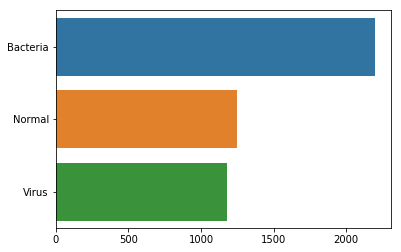

In [6]:
sns.barplot(x=df_train['class'].value_counts().values, y=df_train['class'].value_counts().index)

We have far more cases of bacterial infection than viral and if we combine them for our binary problem we have almost 3 times as many cases of pneumonia than healthy ones.

### Creating an Augmentation Sequence
Below we will create the sequence to augment our data "on-the-fly" to be used in the training of our model.
<br> OneOf allows us to choose one of the below augmentations and apply it to each image in the batch.

In [7]:
seq = iaa.OneOf([iaa.Fliplr(0.5),     # Horizontally flip 50% of the images
                    iaa.Affine(rotate=(-20,20)), # Size of rotation range in degrees
                    iaa.Multiply((1.2, 1.5)), # Makes pixels darker or brighter, random amount between 1.2 and 1.5
                    iaa.Crop(percent=(0, 0.05))
                     ]) 

# There is more one can do here - contrast, rotation etc. - but this is enough to demonstrate its purpose.
# It is better to start simple and slowly build up both the data generator and model to avoid overcomplicating things.
# This allows the user to more easily identify what changes produce which results.

### Creating a Data Generator 
The data generator will be used for training of the model. This will allow us to perform augmentations of the original training data in batches and train upon each one of these.  This is particularly important as it will be used to account for the class imbalance by generating more of the undersampled class for each batch.

Here is one for the multi-class problem, it has been adapted from one created by the user NAIN in this kernel: https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

In [8]:
def data_generator(data, batch_size, directory):
    
    n = len(data)
    steps = n//batch_size
    
    batch_images = np.zeros((batch_size, 224,224,3),dtype=np.float32)
    batch_labels = np.zeros((batch_size, 3),dtype=np.float32)
    
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['file']
            label = data.iloc[idx]['class']            
            
            # read the image and resize
            if "0001" in img_name:
                img = cv2.imread(str(os.path.join("{}normal".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224)) # Setting the size of all the images as 224x224 - standard input size for VGG-16
            
            elif "virus" in img_name:
                img = cv2.imread(str(os.path.join("{}virus".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224))
                                 
            else:
                img = cv2.imread(str(os.path.join("{}bacteria".format(directory),str(img_name))))
                img = cv2.resize(img, (224,224))
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=3)
            
            if img.shape[2]==1:       
                img = np.dstack([img, img, img])  # If grayscale then converts to rgb.
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_images[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img_n = seq.augment_image(img)
                aug_img_n = cv2.cvtColor(aug_img_n, cv2.COLOR_BGR2RGB)
                aug_img_n = aug_img_n.astype(np.float32)/255.

                batch_images[count+1] = aug_img_n
                batch_labels[count+1] = encoded_label
                
                count +=1

            elif label==1 and count < batch_size-2:
                aug_img_v = seq.augment_image(img)
                aug_img_v = cv2.cvtColor(aug_img_v, cv2.COLOR_BGR2RGB)
                aug_img_v = aug_img_v.astype(np.float32)/255.
                
                batch_images[count+2] = aug_img_v
                batch_labels[count+2] = encoded_label

                count +=1
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_images, batch_labels
            
        if i>=steps:
            i=0    
            


### Weighting the classes
If the user wishes to avoid using data generation - class weightings can be used. The weightings are input during  training of the model. Below, the weightings are calculated.

In [9]:
# Find files for each class in training dataset
filer=dp.Files()

# Create list of files
normal = filer.find_files('Docs/all_xrays/train/normal', "0001").files
virus = filer.find_files('Docs/all_xrays/train/virus', "virus").files
bacteria = filer.find_files('Docs/all_xrays/train/bacteria', "bacteria").files

# Sample populations
len(normal),len(bacteria),len(virus)

(1249, 2196, 1179)

In [10]:
# Determine weightings

# 3 Class problem
virus_weighting = len(bacteria)/len(virus)
normal_weighting = len(bacteria)/len(normal)

# Binary Problem
normal_weighting_binary = (len(virus)+len(bacteria))/len(normal)

# Print weights (to 2dp)
round(virus_weighting,2), round(normal_weighting,2), round(normal_weighting_binary,2)

(1.86, 1.76, 2.7)